In [1]:
!pip install pydot graphviz

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, BatchNormalization, Average, Convolution2D, MaxPooling2D, Activation, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D 
from tensorflow.keras.models import Model, Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

from sklearn.metrics import classification_report

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.14.0


In [3]:
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [4]:
cifar10 = keras.datasets.cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

train_labels = keras.utils.to_categorical(train_labels, len(class_names))
test_labels = keras.utils.to_categorical(test_labels, len(class_names))

In [5]:
train_images.shape

(50000, 32, 32, 3)

In [6]:
train_labels.shape

(50000, 10)

In [7]:
train_images = train_images.astype("float32") / 255.0

test_images = test_images.astype("float32") / 255.0

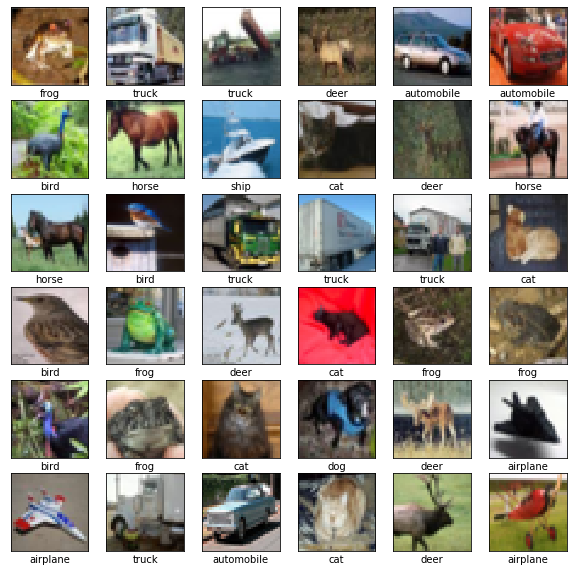

In [8]:
plt.figure(figsize=(10,10))
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].reshape(32,32,3), cmap=plt.cm.binary)
    plt.xlabel(class_names[np.argmax(train_labels[i])])
plt.show()

In [9]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )

In [10]:
if tf.__version__.startswith("1."):
    val_acc_name = "val_acc"
    acc_name = "acc"
else:
    val_acc_name = "val_accuracy"
    acc_name = "accuracy"

In [11]:
EPOCHS = 10000000000
# EPOCHS = 2

## Base like AlexNet implementation

In [12]:
K.clear_session()

inputs = Input(shape=(32,32,3), name="Input")
conv1 = Convolution2D(filters=16, kernel_size=(5,5), strides=4, padding="same", activation="relu")(inputs)
conv2 = Convolution2D(filters=64, kernel_size=(5,5), strides=1, padding="same", activation="relu")(conv1)
batch_norm2 = BatchNormalization()(conv2)
max_pool2 = MaxPooling2D(pool_size=(3,3), strides=2)(batch_norm2)
conv3 = Convolution2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="relu")(max_pool2)
conv4 = Convolution2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="relu")(conv3)
conv5 = Convolution2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="relu")(conv4)
max_pool3 = MaxPooling2D(pool_size=(3,3), strides=2)(conv5)
flatten1 = Flatten()(max_pool3)
dense1 = Dense(512, activation="relu")(flatten1)
dense2 = Dense(512, activation="relu")(dense1)
dense3 = Dense(len(class_names), activation="softmax")(dense2)

model = Model(inputs=[inputs], outputs=[dense3])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 16)          1216      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          25664     
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 64)          256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________

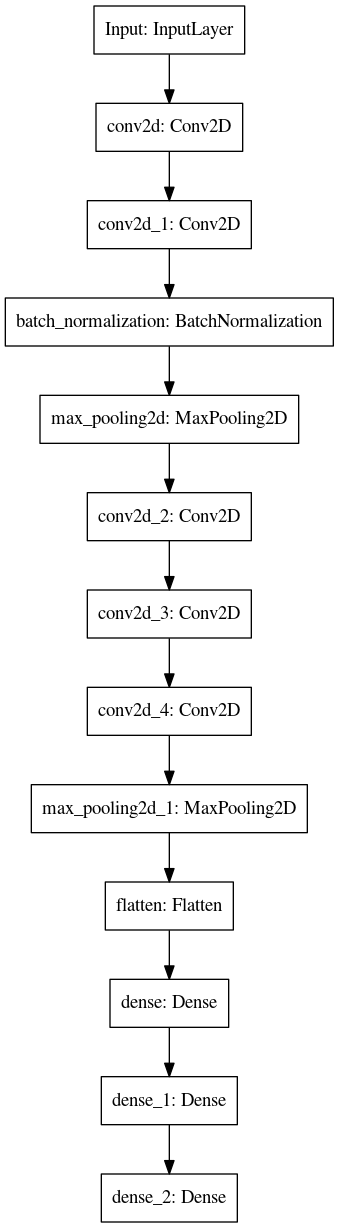

In [13]:
plot_model(model)

In [14]:
checkpoint = ModelCheckpoint('cifar10_base_alexnet.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=5,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [15]:
%%time
BATCH_SIZE = 64

history = model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
                   epochs = EPOCHS,
                   validation_data=(test_images, test_labels),
                   steps_per_epoch=train_images.shape[0] // BATCH_SIZE,
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Epoch 1/10000000000
781/781 [==============================] - 14s 18ms/step - loss: 1.6474 - acc: 0.3916 - val_loss: 1.5182 - val_acc: 0.4617
Epoch 2/10000000000
781/781 [==============================] - 13s 16ms/step - loss: 1.4058 - acc: 0.4910 - val_loss: 1.3185 - val_acc: 0.5239
Epoch 3/10000000000
781/781 [==============================] - 13s 16ms/step - loss: 1.3113 - acc: 0.5301 - val_loss: 1.2297 - val_acc: 0.5642
Epoch 4/10000000000
781/781 [==============================] - 13s 16ms/step - loss: 1.2384 - acc: 0.5574 - val_loss: 1.3308 - val_acc: 0.5216
Epoch 5/10000000000
778/781 [============================>.] - ETA: 0s - loss: 1.1873 - acc: 0.5776
Epoch 00005: val_acc improved from -inf to 0.59260, saving model to cifar10_base_alexnet.hdf5
781/781 [==============================] - 13s 16ms/step - loss: 1.1874 - acc: 0.5775 - val_loss: 1.1335 - val_acc: 0.5926
Epoch 6/10000000000
781/781 [==============================] - 13s 16ms/step - loss: 1.1411 - acc: 0.5942 - val

Epoch 46/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.5932 - acc: 0.7875 - val_loss: 0.8444 - val_acc: 0.7239
Epoch 47/10000000000
777/781 [============================>.] - ETA: 0s - loss: 0.5834 - acc: 0.7924
Epoch 00047: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
781/781 [==============================] - 12s 16ms/step - loss: 0.5835 - acc: 0.7925 - val_loss: 0.9146 - val_acc: 0.7103
Epoch 48/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.5450 - acc: 0.8051 - val_loss: 0.8610 - val_acc: 0.7270
Epoch 49/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.5331 - acc: 0.8104 - val_loss: 0.8457 - val_acc: 0.7272
Epoch 50/10000000000
777/781 [============================>.] - ETA: 0s - loss: 0.5333 - acc: 0.8120
Epoch 00050: val_acc improved from 0.72300 to 0.73310, saving model to cifar10_base_alexnet.hdf5
781/781 [==============================] - 12s 16ms/step - loss: 0

781/781 [==============================] - 12s 16ms/step - loss: 0.4467 - acc: 0.8401 - val_loss: 0.8830 - val_acc: 0.7356
Epoch 88/10000000000
780/781 [============================>.] - ETA: 0s - loss: 0.4423 - acc: 0.8408
Epoch 00088: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
781/781 [==============================] - 12s 16ms/step - loss: 0.4424 - acc: 0.8408 - val_loss: 0.8821 - val_acc: 0.7358
Epoch 89/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4412 - acc: 0.8418 - val_loss: 0.8831 - val_acc: 0.7360
Epoch 90/10000000000
778/781 [============================>.] - ETA: 0s - loss: 0.4463 - acc: 0.8424
Epoch 00090: val_acc did not improve from 0.73580
781/781 [==============================] - 12s 16ms/step - loss: 0.4462 - acc: 0.8423 - val_loss: 0.8825 - val_acc: 0.7354
Epoch 91/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4417 - acc: 0.8419 - val_loss: 0.8818 - val_acc: 0.7357
Epoch 92/1

781/781 [==============================] - 12s 16ms/step - loss: 0.4433 - acc: 0.8411 - val_loss: 0.8826 - val_acc: 0.7357
Epoch 128/10000000000
781/781 [==============================] - 13s 16ms/step - loss: 0.4430 - acc: 0.8408 - val_loss: 0.8827 - val_acc: 0.7359
Epoch 129/10000000000
777/781 [============================>.] - ETA: 0s - loss: 0.4337 - acc: 0.8437
Epoch 00129: ReduceLROnPlateau reducing learning rate to 1e-08.
781/781 [==============================] - 12s 16ms/step - loss: 0.4332 - acc: 0.8438 - val_loss: 0.8837 - val_acc: 0.7353
Epoch 130/10000000000
779/781 [============================>.] - ETA: 0s - loss: 0.4403 - acc: 0.8437
Epoch 00130: val_acc did not improve from 0.73590
781/781 [==============================] - 12s 16ms/step - loss: 0.4402 - acc: 0.8438 - val_loss: 0.8830 - val_acc: 0.7350
Epoch 131/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4385 - acc: 0.8440 - val_loss: 0.8822 - val_acc: 0.7358
Epoch 132/10000000000
7

781/781 [==============================] - 12s 16ms/step - loss: 0.4414 - acc: 0.8410 - val_loss: 0.8830 - val_acc: 0.7348
Epoch 175/10000000000
779/781 [============================>.] - ETA: 0s - loss: 0.4423 - acc: 0.8429
Epoch 00175: val_acc improved from 0.73600 to 0.73610, saving model to cifar10_base_alexnet.hdf5
781/781 [==============================] - 12s 16ms/step - loss: 0.4423 - acc: 0.8429 - val_loss: 0.8821 - val_acc: 0.7361
Epoch 176/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4426 - acc: 0.8426 - val_loss: 0.8823 - val_acc: 0.7353
Epoch 177/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4450 - acc: 0.8426 - val_loss: 0.8834 - val_acc: 0.7357
Epoch 178/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4502 - acc: 0.8404 - val_loss: 0.8830 - val_acc: 0.7356
Epoch 179/10000000000
781/781 [==============================] - 12s 16ms/step - loss: 0.4341 - acc: 0.8449 - val_loss: 

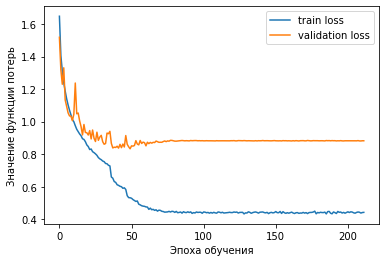

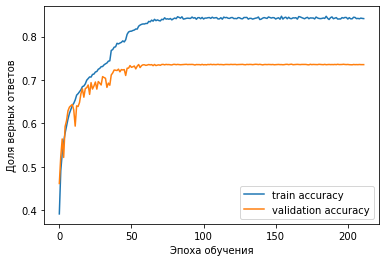

In [16]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [17]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 0s 46us/sample - loss: 0.8826 - acc: 0.7363


[0.8826146543979645, 0.7363]

In [18]:
preds = model.predict(test_images)

print("Test data evaluation:")
print(classification_report(test_labels.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

    airplane       0.76      0.81      0.78      1000
  automobile       0.80      0.86      0.83      1000
        bird       0.71      0.61      0.66      1000
         cat       0.60      0.53      0.56      1000
        deer       0.70      0.65      0.67      1000
         dog       0.65      0.64      0.64      1000
        frog       0.72      0.83      0.77      1000
       horse       0.78      0.81      0.79      1000
        ship       0.86      0.83      0.85      1000
       truck       0.75      0.81      0.78      1000

    accuracy                           0.74     10000
   macro avg       0.73      0.74      0.73     10000
weighted avg       0.73      0.74      0.73     10000



## Advanced model

In [19]:
K.clear_session()

inputs = Input(shape=(32,32,3), name="Input")

# MaxPoolingNet
conv1 = Convolution2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="elu")(inputs)
batch_norm1 = BatchNormalization()(conv1)
conv2 = Convolution2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="elu")(batch_norm1)
batch_norm2 = BatchNormalization()(conv2)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=1)(batch_norm2)
drop1 = Dropout(0.2)(max_pool1)

conv3 = Convolution2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="elu")(drop1)
batch_norm3 = BatchNormalization()(conv3)
conv4 = Convolution2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="elu")(batch_norm3)
batch_norm4 = BatchNormalization()(conv4)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=1)(batch_norm4)
drop2 = Dropout(0.3)(max_pool2)

conv5 = Convolution2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="elu")(drop2)
batch_norm5 = BatchNormalization()(conv5)
conv6 = Convolution2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="elu")(batch_norm5)
batch_norm6 = BatchNormalization()(conv6)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=1)(batch_norm6)
drop3 = Dropout(0.4)(max_pool3)

flat1 = Flatten()(drop3)


# AvgPoolingNet
conv1_2 = Convolution2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="elu")(inputs)
batch_norm1_2 = BatchNormalization()(conv1_2)
conv2_2 = Convolution2D(filters=32, kernel_size=(3,3), strides=1, padding="same", activation="elu")(batch_norm1_2)
batch_norm2_2 = BatchNormalization()(conv2_2)
avg_pool1 = AveragePooling2D(pool_size=(2,2), strides=1)(batch_norm2_2)
drop1_2 = Dropout(0.2)(avg_pool1)

conv3_2 = Convolution2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="elu")(drop1_2)
batch_norm3_2 = BatchNormalization()(conv3_2)
conv4_2 = Convolution2D(filters=64, kernel_size=(3,3), strides=1, padding="same", activation="elu")(batch_norm3_2)
batch_norm4_2 = BatchNormalization()(conv4_2)
avg_pool2 = AveragePooling2D(pool_size=(2,2), strides=1)(batch_norm4_2)
drop2_2 = Dropout(0.3)(avg_pool2)

conv5_2 = Convolution2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="elu")(drop2_2)
batch_norm5_2 = BatchNormalization()(conv5_2)
conv6_2 = Convolution2D(filters=128, kernel_size=(3,3), strides=1, padding="same", activation="elu")(batch_norm5_2)
batch_norm6_2 = BatchNormalization()(conv6_2)
avg_pool3 = AveragePooling2D(pool_size=(2,2), strides=1)(batch_norm6_2)
drop3_2 = Dropout(0.4)(avg_pool3)

flat2 = Flatten()(drop3_2)


# Concatenate
concat = Concatenate()([flat1, flat2])

dense1 = Dense(len(class_names), activation="softmax")(concat)

model = Model(inputs=[inputs], outputs=[dense1])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.summary()



Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         Input[0][0]                      
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   896         Input[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
______________________________________________________________________________________________

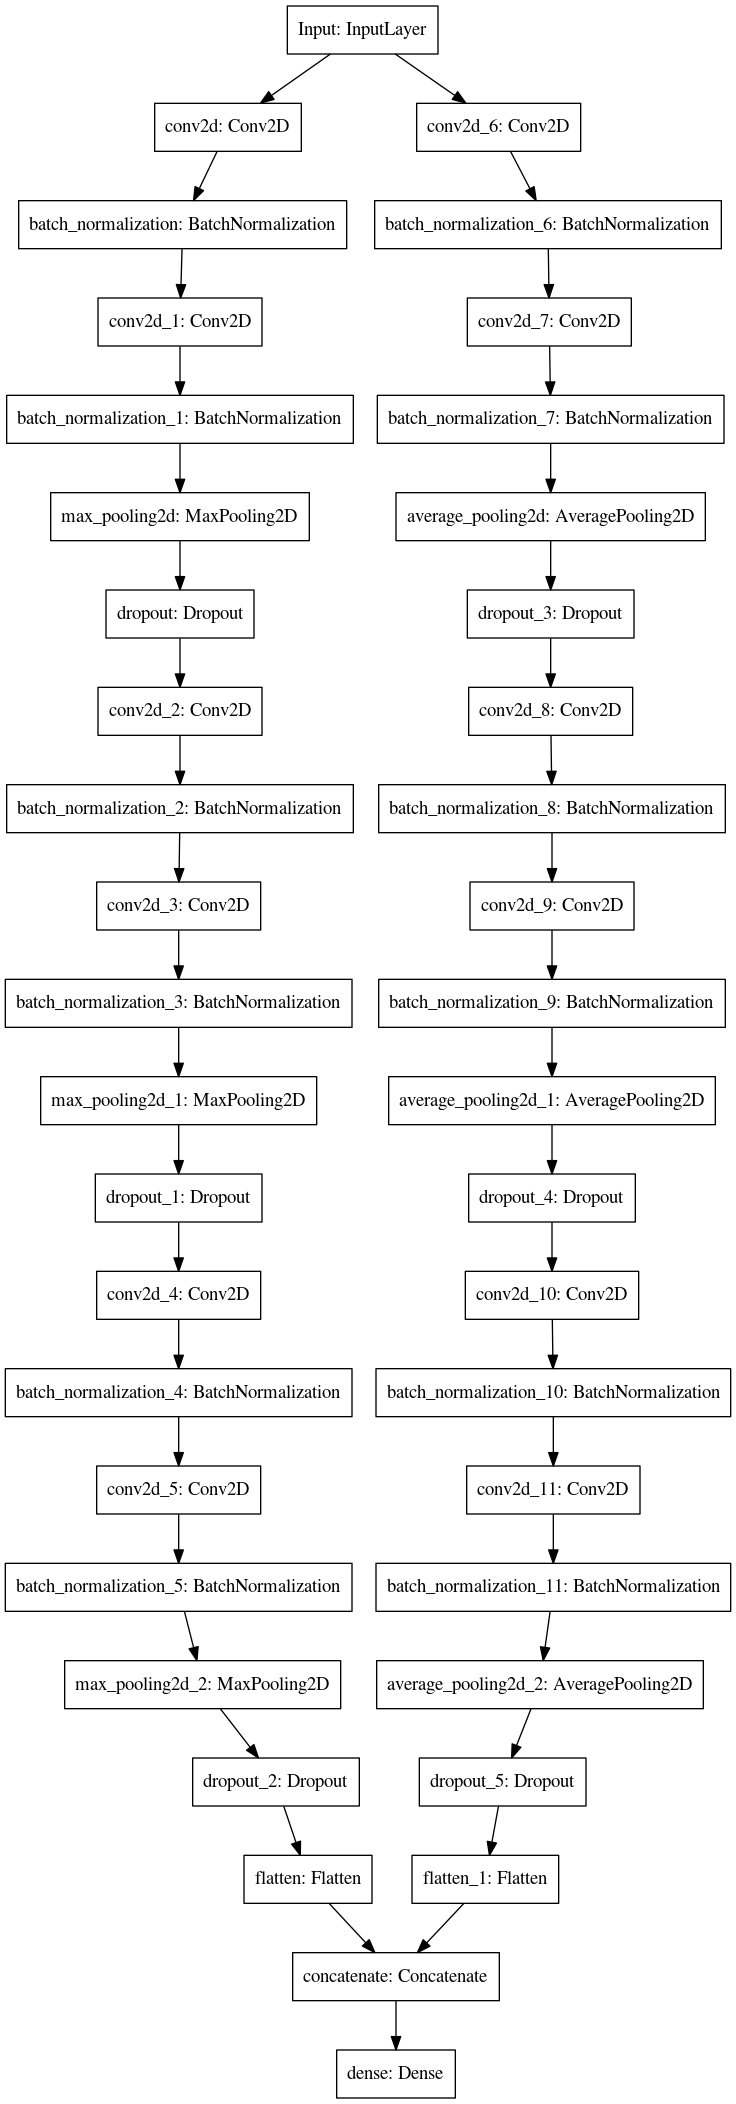

In [20]:
plot_model(model)

In [21]:
checkpoint = ModelCheckpoint('cifar10_advanced_model.hdf5',
                            monitor=val_acc_name,
                            save_best_only=True,
                            period=5,
                            verbose=1)
early_stopping_callback = EarlyStopping(monitor=val_acc_name, 
                                        min_delta=1e-9, 
                                        patience=50, 
                                        verbose=1, 
                                        mode='auto', 
                                        baseline=None, 
                                        restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor=val_acc_name,
                                           patience=5,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00000001)

In [22]:
%%time
BATCH_SIZE = 128

history = model.fit(datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE),
                   epochs = EPOCHS,
                   validation_data=(test_images, test_labels),
                   steps_per_epoch=train_images.shape[0] // BATCH_SIZE,
                   verbose=1,
                   callbacks=[checkpoint, learning_rate_reduction, early_stopping_callback])

Epoch 1/10000000000
390/390 [==============================] - 62s 159ms/step - loss: 14.4655 - acc: 0.3664 - val_loss: 17.1478 - val_acc: 0.1947
Epoch 2/10000000000
390/390 [==============================] - 60s 153ms/step - loss: 8.0680 - acc: 0.4485 - val_loss: 5.3854 - val_acc: 0.4925
Epoch 3/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 4.5289 - acc: 0.4809 - val_loss: 3.6273 - val_acc: 0.4686
Epoch 4/10000000000
390/390 [==============================] - 59s 153ms/step - loss: 2.1847 - acc: 0.5313 - val_loss: 1.5216 - val_acc: 0.6112
Epoch 5/10000000000
389/390 [============================>.] - ETA: 0s - loss: 1.3817 - acc: 0.5826
Epoch 00005: val_acc improved from -inf to 0.62250, saving model to cifar10_advanced_model.hdf5
390/390 [==============================] - 60s 154ms/step - loss: 1.3812 - acc: 0.5827 - val_loss: 1.2637 - val_acc: 0.6225
Epoch 6/10000000000
390/390 [==============================] - 60s 153ms/step - loss: 1.1243 - acc: 0.

Epoch 46/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.3706 - acc: 0.8707 - val_loss: 0.5298 - val_acc: 0.8402
Epoch 47/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.3634 - acc: 0.8727 - val_loss: 0.5293 - val_acc: 0.8402
Epoch 48/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.3645 - acc: 0.8737 - val_loss: 0.5993 - val_acc: 0.8223
Epoch 49/10000000000
389/390 [============================>.] - ETA: 0s - loss: 0.3561 - acc: 0.8747
Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
390/390 [==============================] - 59s 152ms/step - loss: 0.3560 - acc: 0.8746 - val_loss: 0.5239 - val_acc: 0.8367
Epoch 50/10000000000
389/390 [============================>.] - ETA: 0s - loss: 0.3348 - acc: 0.8829
Epoch 00050: val_acc improved from 0.82960 to 0.84780, saving model to cifar10_advanced_model.hdf5
390/390 [==============================] - 60s 153ms/step - 

390/390 [==============================] - 59s 152ms/step - loss: 0.2362 - acc: 0.9168 - val_loss: 0.4779 - val_acc: 0.8625
Epoch 90/10000000000
389/390 [============================>.] - ETA: 0s - loss: 0.2403 - acc: 0.9147
Epoch 00090: val_acc improved from 0.86070 to 0.86280, saving model to cifar10_advanced_model.hdf5
390/390 [==============================] - 59s 153ms/step - loss: 0.2401 - acc: 0.9148 - val_loss: 0.4814 - val_acc: 0.8628
Epoch 91/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.2351 - acc: 0.9173 - val_loss: 0.4708 - val_acc: 0.8652
Epoch 92/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.2419 - acc: 0.9138 - val_loss: 0.4719 - val_acc: 0.8663
Epoch 93/10000000000
390/390 [==============================] - 60s 153ms/step - loss: 0.2352 - acc: 0.9166 - val_loss: 0.4843 - val_acc: 0.8616
Epoch 94/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.2338 - acc: 0.9186 - val_los

Epoch 130/10000000000
389/390 [============================>.] - ETA: 0s - loss: 0.2239 - acc: 0.9202
Epoch 00130: val_acc did not improve from 0.86510
390/390 [==============================] - 59s 152ms/step - loss: 0.2239 - acc: 0.9202 - val_loss: 0.4795 - val_acc: 0.8641
Epoch 131/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.2312 - acc: 0.9175 - val_loss: 0.4799 - val_acc: 0.8642
Epoch 132/10000000000
389/390 [============================>.] - ETA: 0s - loss: 0.2276 - acc: 0.9208
Epoch 00132: ReduceLROnPlateau reducing learning rate to 6.103515914901436e-08.
390/390 [==============================] - 59s 152ms/step - loss: 0.2276 - acc: 0.9207 - val_loss: 0.4790 - val_acc: 0.8642
Epoch 133/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.2273 - acc: 0.9206 - val_loss: 0.4792 - val_acc: 0.8643
Epoch 134/10000000000
390/390 [==============================] - 59s 152ms/step - loss: 0.2263 - acc: 0.9204 - val_loss: 0.479

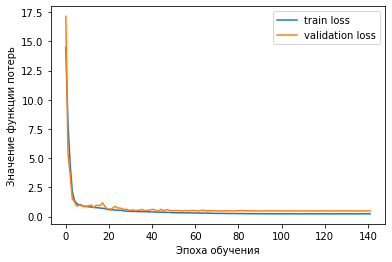

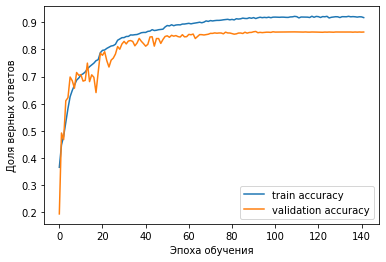

In [23]:
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(history.history[acc_name], label='train accuracy')
plt.plot(history.history[val_acc_name], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

In [24]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 4s 376us/sample - loss: 0.4749 - acc: 0.8663


[0.47489567680358885, 0.8663]

In [25]:
preds = model.predict(test_images)

print("Test data evaluation:")
print(classification_report(test_labels.argmax(axis=1), preds.argmax(axis=1), target_names=class_names))

Test data evaluation:
              precision    recall  f1-score   support

    airplane       0.90      0.87      0.89      1000
  automobile       0.93      0.94      0.93      1000
        bird       0.79      0.84      0.82      1000
         cat       0.83      0.70      0.76      1000
        deer       0.82      0.86      0.84      1000
         dog       0.90      0.75      0.82      1000
        frog       0.82      0.95      0.88      1000
       horse       0.90      0.90      0.90      1000
        ship       0.91      0.93      0.92      1000
       truck       0.88      0.93      0.91      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

